In [1]:
import pennylane as qml
from pennylane import numpy as np
import random





def ising_model_circuit(num_qubits=4,num_layer = 2,single='X',double='ZZ',J=0.25,h=0.125):
    """
    Creates a parameterized quantum circuit for simulating the Ising model
    with specified number of qubits and layers. The circuit includes random 
    interaction strengths and external field strengths.
    
    Args:
    num_qubits (int): Number of qubits in the circuit.
    num_layer (int): Number of layers of Ising interactions and external field terms.
    
    Returns:
    cost (function): The cost function which returns the expected value of the PauliZ observable on the first qubit.
    """
    
    
    # Define the device
    dev = qml.device("default.mixed", wires=num_qubits)
    
    # Define random interaction strengths and external field strengths
    J = np.array(list([J])*num_qubits)
    h = np.array(list([h])*num_qubits)

    def circuit(params):
        # Apply RX rotations with parameters
        for i in range(num_qubits):
            getattr(qml,f"R{single}")(params[i], wires=i)
        for j in range(num_layer):
            # Apply Ising ZZ interactions
            for i in range(num_qubits - 1):
                getattr(qml,f"Ising{double}")(2 * J[i], wires=[i, i+1])

            
            # Apply external field X terms
            for i in range(num_qubits):
                qml.RX(2 * h[i], wires=i)

    # Define the Ising model Hamiltonian
    coeffs = []
    obs = []

    @qml.qnode(dev,interface='torch')
    def cost(params):
        circuit(params)
        return qml.expval(qml.Identity(0))
    
    return cost

# Example usage
num_parameters = 4  # One parameter per qubit for RX rotations
params = list(np.random.uniform(0, 2 * np.pi, num_parameters))
random_circuit = ising_model_circuit(4,single='Y',double='XX')
print(random_circuit(params))
print(qml.draw(random_circuit)(params))

0.9999999999999987
0: ──RY(1.77)─╭IsingXX(0.50)──RX(0.25)─────────────────────╭IsingXX(0.50)──RX(0.25)─────
1: ──RY(2.66)─╰IsingXX(0.50)─╭IsingXX(0.50)──RX(0.25)──────╰IsingXX(0.50)─╭IsingXX(0.50)
2: ──RY(5.06)────────────────╰IsingXX(0.50)─╭IsingXX(0.50)──RX(0.25)──────╰IsingXX(0.50)
3: ──RY(3.04)───────────────────────────────╰IsingXX(0.50)──RX(0.25)────────────────────

───────────────────────────┤  <I>
───RX(0.25)────────────────┤     
──╭IsingXX(0.50)──RX(0.25)─┤     
──╰IsingXX(0.50)──RX(0.25)─┤     


In [2]:
meas1 = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])
meas2 = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])

In [98]:
from functions.Error_mitigation import extra_polation,extra_polation_time
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
import pennylane as qml


# 데이터셋 생성 클래스
class QuantumData_time(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 3, 5],size=50):
        """
        QuantumData_time 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            # 0에서 2π 사이의 랜덤 theta 값 6개 생성
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(para_num)]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation_time(circuit, meas, theta, noise_factor=input_list, p1=0.1, p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# 데이터셋 생성 클래스
class QuantumData_gate(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 1.2, 1.4],size=50):
        """
        QuantumData_gate 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            # 0에서 2π 사이의 랜덤 theta 값 6개 생성
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(para_num)]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation(circuit, meas, theta, noise_factor=input_list, p1=0.1, p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


input_list1 = [0,0.25,0.5]
input_list2 = [1,1.5,2,2.5,3]
# 데이터셋 및 데이터 로더 생성
dataset_temp = QuantumData_time(random_circuit,meas1,input_list1,size=50)
dataset = QuantumData_time(random_circuit,meas1,input_list2,size=50)
train_size = int(0.8 * len(dataset))   
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=15, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [00:42<00:17,  1.25s/it]

In [ ]:
theta = [np.random.uniform(0, 2 * np.pi) for i in range(4)]
theta 

[4.0340038058609435, 0.5286669918034955, 1.0155431616176074, 5.64578247505802]

In [ ]:
import pickle as pkl
pkl_data = {}
pkl_data['circuit'] = qml.draw(random_circuit)(params)
pkl_data['data'] = dataset,input_list2
pkl_data['inform'] = "p1=0.01,p2=0.01 로 구성되어 있고 서킷에 노이즈를 가한 결과, parameter : 초기 x gate 4개"

with open('./data/Quantum_data_2.pkl','wb') as file:
    pkl.dump(pkl_data,file)


In [ ]:
# 데이터셋 및 데이터 로더 생성

train_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(len(input_list2), 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.GELU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return torch.squeeze(self.fc3(x))

model_MLP = RegressionModel()
criterion = nn.MSELoss()
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.01)

from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([len(input_list2),1,1],grid=5)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output
    
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

model = Model()
LSTM_model = LSTMModel(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer_LSTM = torch.optim.Adam(LSTM_model.parameters(), lr=0.05)

In [ ]:
from functions.training import Early_stop_train,Early_stop_train_KAN,accuracy

In [ ]:
#from functions.training import Early_stop_train_KAN

train_seq_KAN = Early_stop_train_KAN(model,optimizer,criterion)

train_seq_KAN.train_model(train_loader,val_loader,res=10)

C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)



Test set: Average loss: 0.5827, Accuracy: 0.0/25 (0%)
Epoch 1 Loss 0.528362 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.4579, Accuracy: 0.0/25 (0%)
Epoch 2 Loss 0.434384 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3564, Accuracy: 0.0/25 (0%)
Epoch 3 Loss 0.345132 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2795, Accuracy: 0.0/25 (0%)
Epoch 4 Loss 0.264756 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2346, Accuracy: 0.0/25 (0%)
Epoch 5 Loss 0.212600 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2168, Accuracy: 0.0/25 (0%)
Epoch 6 Loss 0.189644 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2177, Accuracy: 0.0/25 (0%)
Epoch 7 Loss 0.189219 acc : 0.000000 reg : 0.000000 stop count : 1
Test set: Average loss: 0.2254, Accuracy: 0.0/25 (0%)
Epoch 8 Loss 0.199187 acc : 0.000000 reg : 0.000000 stop count : 2
Test set: Average loss: 0.2281,

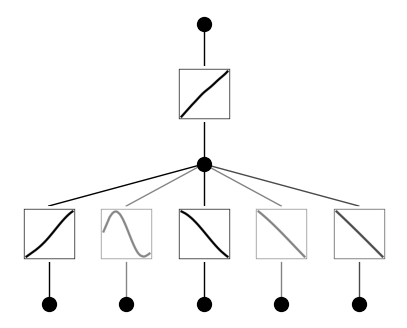

In [ ]:
model.KAN.plot(beta=15)

In [ ]:
#from functions.training import Early_stop_train

train_seq = Early_stop_train(model_MLP,optimizer_MLP,criterion)
train_seq.train_model(train_loader,val_loader)

C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)



Test set: Average loss: 0.6325, Accuracy: 0.0/25 (0%)
Epoch 1 Loss 0.575292 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5792, Accuracy: 0.0/25 (0%)
Epoch 2 Loss 0.533138 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5225, Accuracy: 0.0/25 (0%)
Epoch 3 Loss 0.487984 acc : 0.000000 stop count : 0
Test set: Average loss: 0.4596, Accuracy: 0.0/25 (0%)
Epoch 4 Loss 0.437401 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3899, Accuracy: 0.0/25 (0%)
Epoch 5 Loss 0.380450 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3149, Accuracy: 0.0/25 (0%)
Epoch 6 Loss 0.318484 acc : 0.000000 stop count : 0
Test set: Average loss: 0.2402, Accuracy: 0.0/25 (0%)
Epoch 7 Loss 0.255838 acc : 0.000000 stop count : 0
Test set: Average loss: 0.1756, Accuracy: 0.0/25 (0%)
Epoch 8 Loss 0.199715 acc : 0.000000 stop count : 0
Test set: Average loss: 0.1329, Accuracy: 0.0/25 (0%)
Epoch 9 Loss 0.158557 acc : 0.000000 stop count : 0
Test set: Average loss: 0.1222, Accuracy: 0.0

In [ ]:

train_seq_LSTM = Early_stop_train(LSTM_model,optimizer_LSTM,criterion)
train_seq_LSTM.train_model(train_loader,val_loader)


Test set: Average loss: 0.6455, Accuracy: 0.0/25 (0%)
Epoch 1 Loss 0.600563 acc : 0.000000 stop count : 0
Test set: Average loss: 0.8073, Accuracy: 0.0/25 (0%)


C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


Epoch 2 Loss 0.709528 acc : 0.000000 stop count : 1
Test set: Average loss: 0.6296, Accuracy: 0.0/25 (0%)
Epoch 3 Loss 0.577352 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6314, Accuracy: 0.0/25 (0%)
Epoch 4 Loss 0.598096 acc : 0.000000 stop count : 1
Test set: Average loss: 0.6273, Accuracy: 0.0/25 (0%)
Epoch 5 Loss 0.594893 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6186, Accuracy: 0.0/25 (0%)
Epoch 6 Loss 0.580930 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6101, Accuracy: 0.0/25 (0%)
Epoch 7 Loss 0.567184 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5855, Accuracy: 0.0/25 (0%)
Epoch 8 Loss 0.541836 acc : 0.000000 stop count : 0
Test set: Average loss: 0.4978, Accuracy: 0.0/25 (0%)
Epoch 9 Loss 0.466618 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3338, Accuracy: 0.0/25 (0%)
Epoch 10 Loss 0.342241 acc : 0.000000 stop count : 0
Test set: Average loss: 0.1970, Accuracy: 0.0/25 (0%)
Epoch 11 Loss 0.188137 acc : 0.000000 stop co

In [ ]:
from functions.Error_mitigation import extrapolate_values

y_lin_list = []
y_exp_list = []
y_list = []
x_list = []

for x,y in tqdm(val_dataset):
    y_linear_0, y_exp_0,_,_= extrapolate_values(x,x_data=input_list2)
    y_lin_list.append(y_linear_0)
    y_exp_list.append(y_exp_0)
    y_list.append(y)
    x_list.append(float(x[0]))

x_list,y_lin_list,y_exp_list ,y_list = torch.tensor(x_list),torch.tensor(y_lin_list).float(),torch.tensor(y_exp_list).float(),torch.tensor(y_list).float()

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)
100%|██████████| 25/25 [00:00<00:00, 26.41it/s]


In [ ]:
Lin_loss = torch.nn.MSELoss()(y_lin_list,y_list).item()
exp_loss = torch.nn.MSELoss()(y_exp_list,y_list).item()
raw_loss = torch.nn.MSELoss()(x_list,y_list).item()



In [ ]:
for x,y in val_loader:
    x

C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [ ]:
LSTM_output = torch.squeeze(LSTM_model(x))
KAN_output = torch.squeeze(model(x))
MLP_output = torch.squeeze(model_MLP(x))

MLP_loss = torch.nn.MSELoss()(MLP_output,y_list).item()
KAN_loss = torch.nn.MSELoss()(KAN_output,y_list).item()
LSTM_loss = torch.nn.MSELoss()(LSTM_output,y_list).item()


In [ ]:
loss_list = {'lin':Lin_loss,'exp':exp_loss,'raw':raw_loss,'MLP':MLP_loss,'KAN':KAN_loss,'LSTM':LSTM_loss}

for name,loss in loss_list.items():
    print(f"{name} = {loss}")

lin = 0.1744445413351059
exp = 0.8328470587730408
raw = 0.25493985414505005
MLP = 0.005697695538401604
KAN = 0.002767876721918583
LSTM = 0.08471595495939255


In [ ]:
for index,(x,y) in enumerate(dataset_temp):
    print(x,y)

C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


tensor([-0.4514, -0.4717]) tensor(-0.4514)
tensor([0.7748, 0.4901]) tensor(0.7748)
tensor([ 0.0056, -0.0269]) tensor(0.0056)
tensor([-0.0364,  0.0624]) tensor(-0.0364)
tensor([-0.1357, -0.1565]) tensor(-0.1357)
tensor([0.2979, 0.0370]) tensor(0.2979)
tensor([-0.8278, -0.6511]) tensor(-0.8278)
tensor([0.4556, 0.2149]) tensor(0.4556)
tensor([1.3458, 0.8710]) tensor(1.3458)
tensor([-0.1906, -0.2983]) tensor(-0.1906)
tensor([1.0618, 0.6978]) tensor(1.0618)
tensor([ 0.0880, -0.0612]) tensor(0.0880)
tensor([0.9362, 0.4162]) tensor(0.9362)
tensor([1.2985, 0.9164]) tensor(1.2985)
tensor([-0.7271, -0.2999]) tensor(-0.7271)
tensor([-0.9516, -0.5835]) tensor(-0.9516)
tensor([0.7476, 0.3528]) tensor(0.7476)
tensor([1.3947, 0.8486]) tensor(1.3947)
tensor([0.8929, 0.5897]) tensor(0.8929)
tensor([0.9658, 0.5280]) tensor(0.9658)
tensor([-0.0934,  0.1367]) tensor(-0.0934)
tensor([-1.0765, -0.6528]) tensor(-1.0765)
tensor([0.1353, 0.1312]) tensor(0.1353)
tensor([-0.8562, -0.6153]) tensor(-0.8562)
tensor

C:\Users\pop75\AppData\Local\Temp\ipykernel_22240\271965558.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


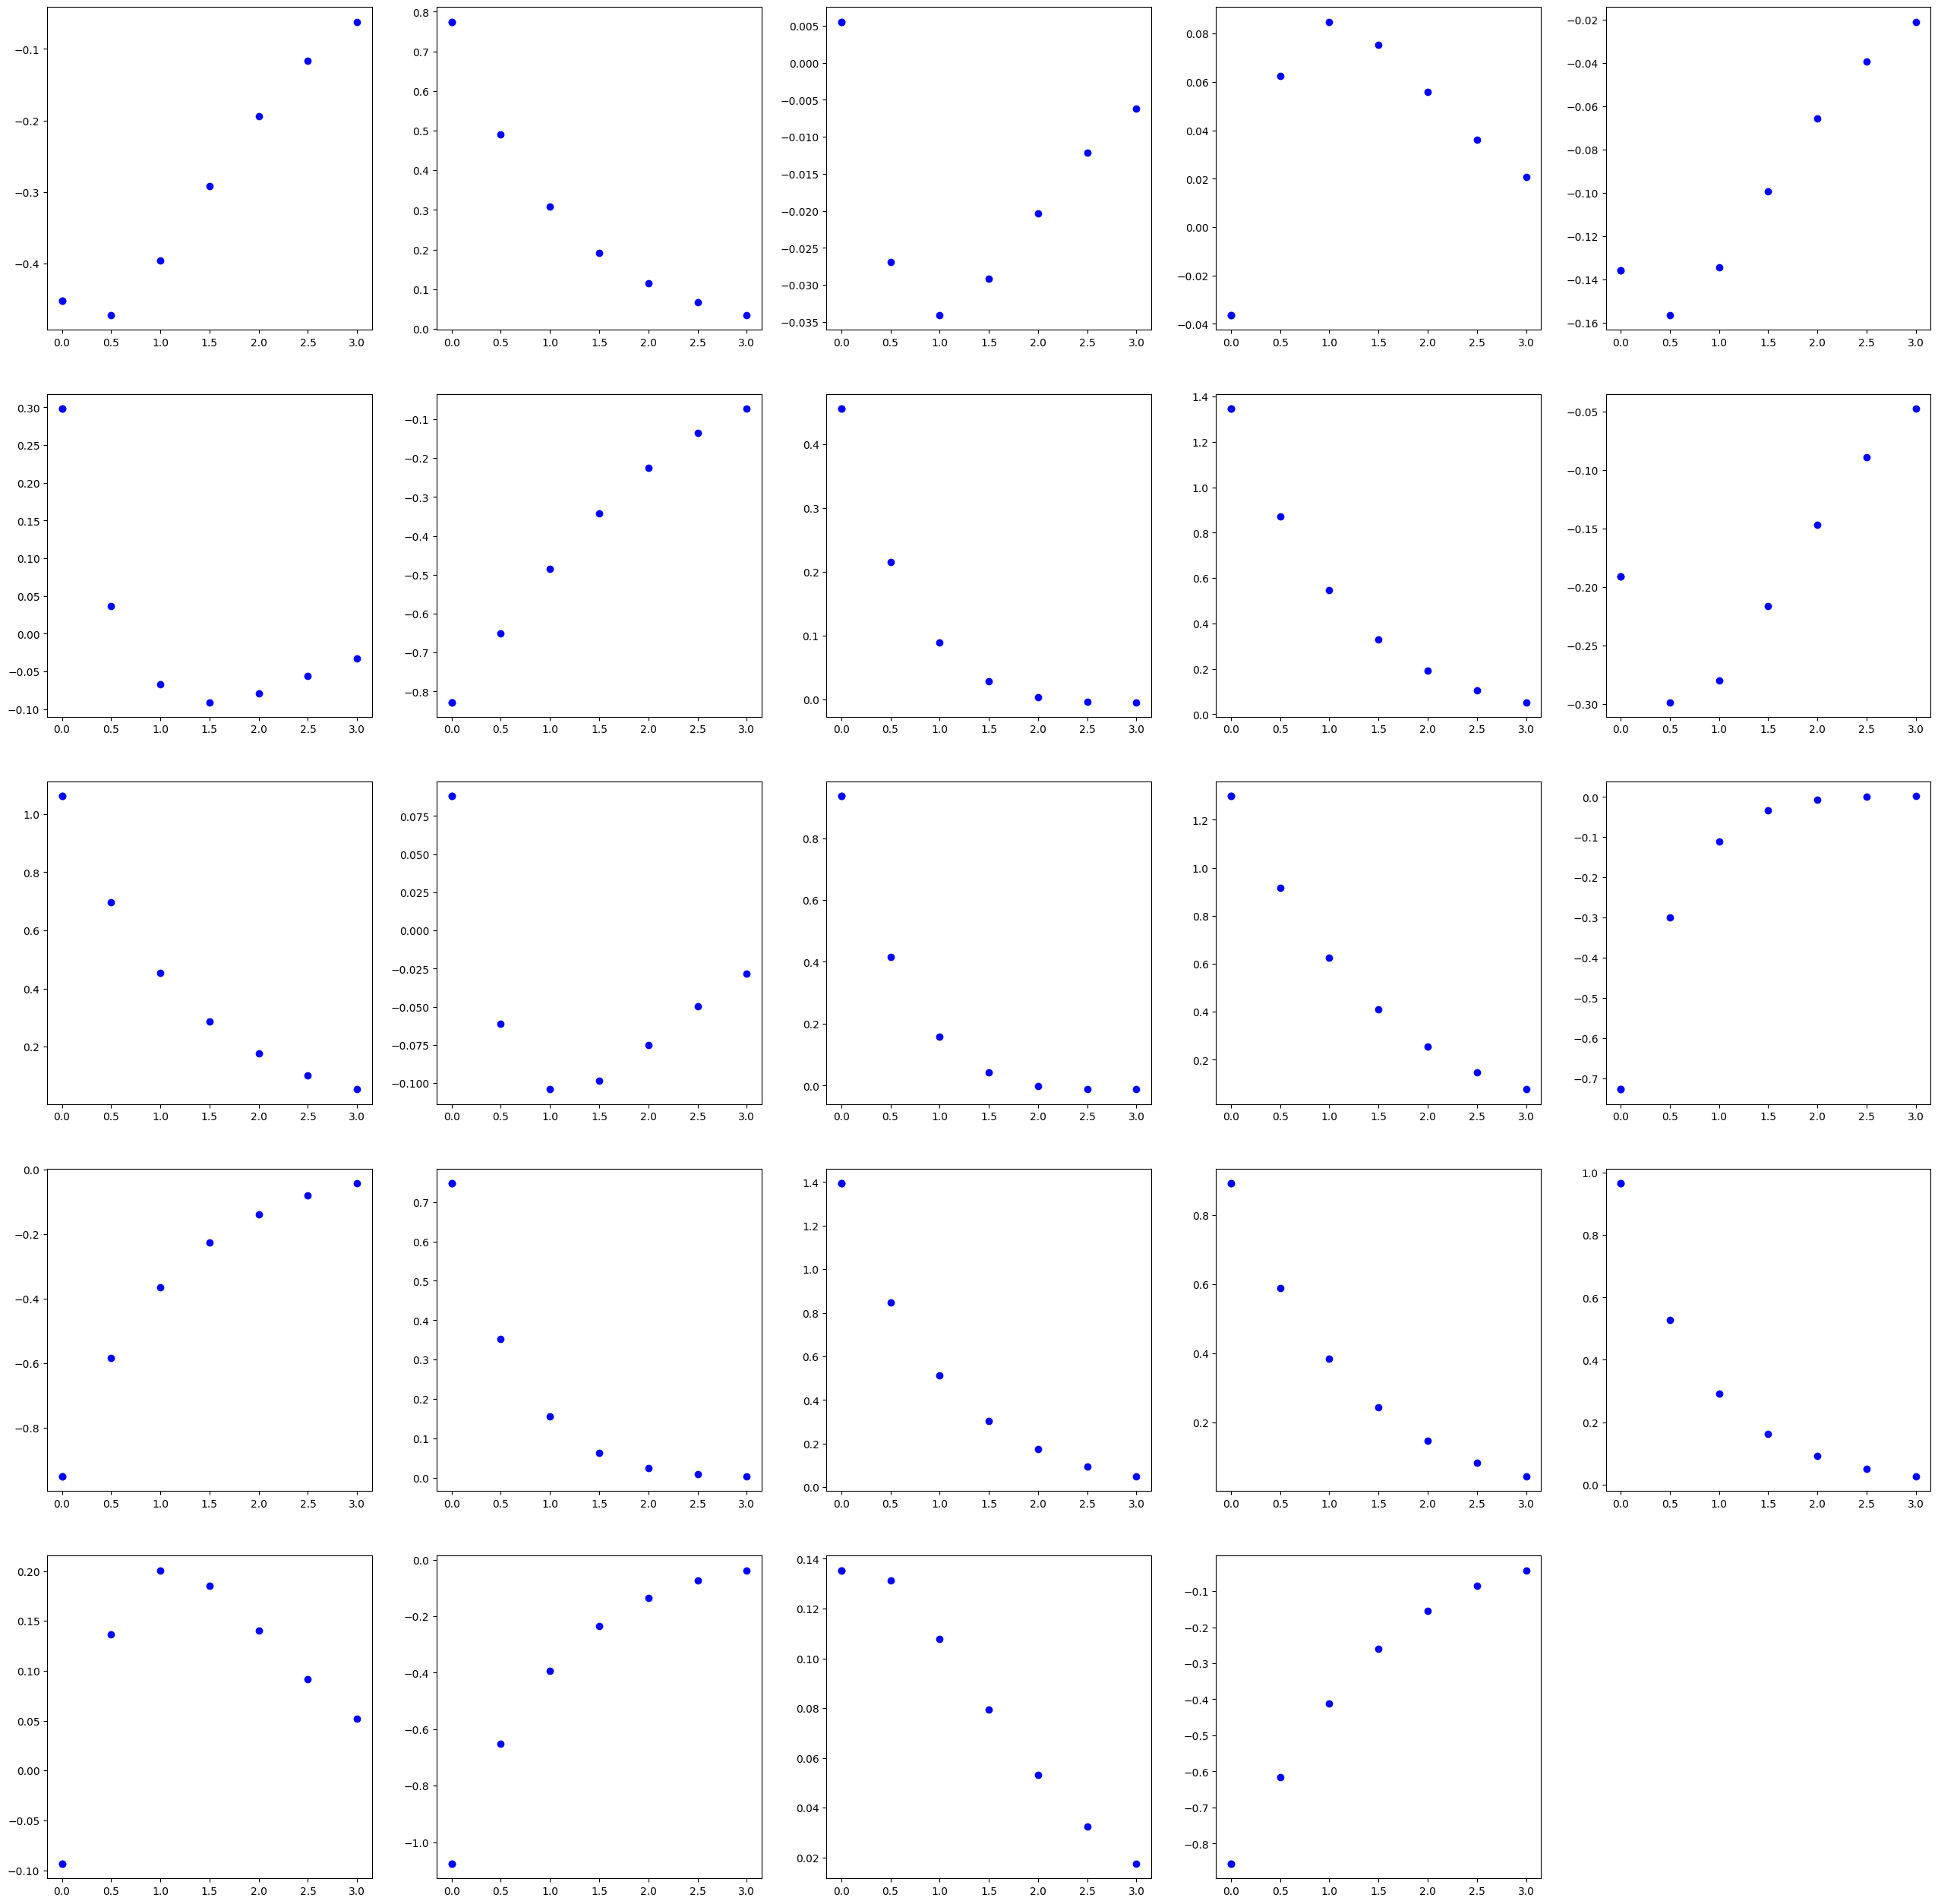

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(32,32))
index = 1
for (x,y),(x1,y1) in zip(dataset,dataset_temp):
    if index <25:
        plt.subplot(5,5,index)
        plt.plot([0]+input_list1+input_list2,list([y])+list(x1)+list(x),'bo')
        index+=1
    else:
        break

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(32,32))
for index,(x,y) in enumerate(dataset):
    index = index+1
    if index <25:
        plt.subplot(5,5,index)
        plt.plot([0]+input_list,list([y])+list(x),'bo')
        index+=1
    else:
        break

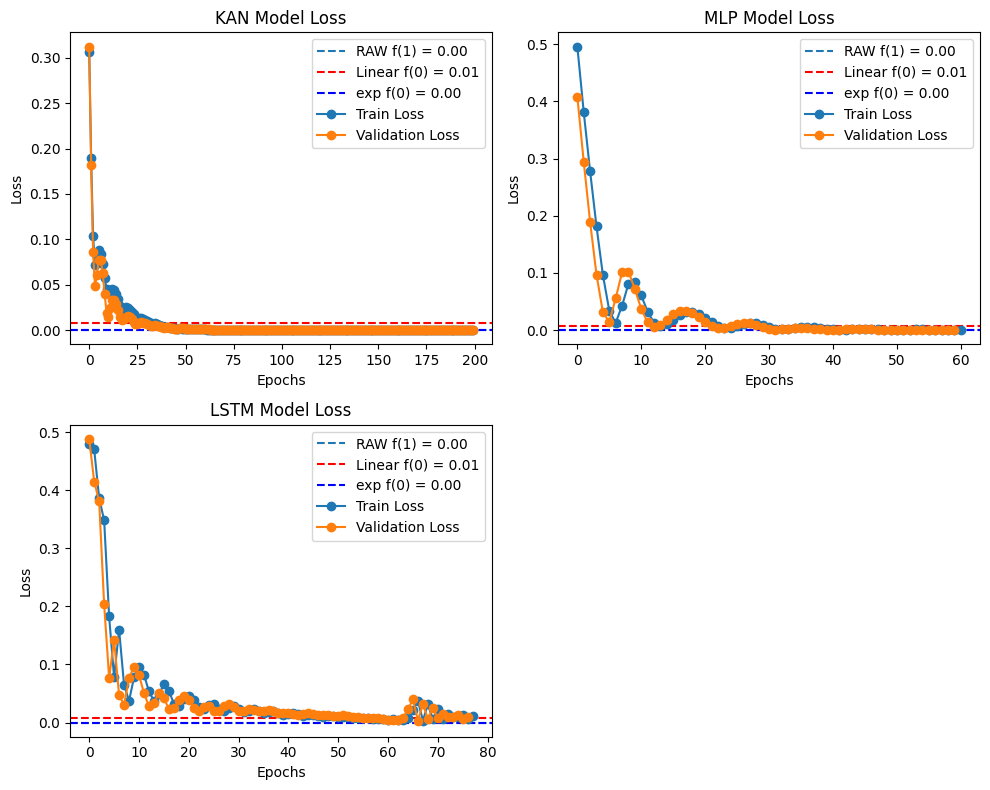

In [19]:
import matplotlib.pyplot as plt



# 예시 데이터
KAN_model_train_loss = train_seq_KAN.train_loss_list
KAN_model_val_loss = train_seq_KAN.loss_list
MLP_model_train_loss = train_seq.train_loss_list
MLP_model_val_loss = train_seq.loss_list
LSTM_model_train_loss = train_seq_LSTM.train_loss_list
LSTM_model_val_loss = train_seq_LSTM.loss_list







# KAN 모델 Loss 플롯
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")

plt.plot(KAN_model_train_loss, label='Train Loss', marker='o')
plt.plot(KAN_model_val_loss, label='Validation Loss', marker='o')
plt.title('KAN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 2)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(MLP_model_train_loss, label='Train Loss', marker='o')
plt.plot(MLP_model_val_loss, label='Validation Loss', marker='o')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 3)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(LSTM_model_train_loss, label='Train Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='Validation Loss', marker='o')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


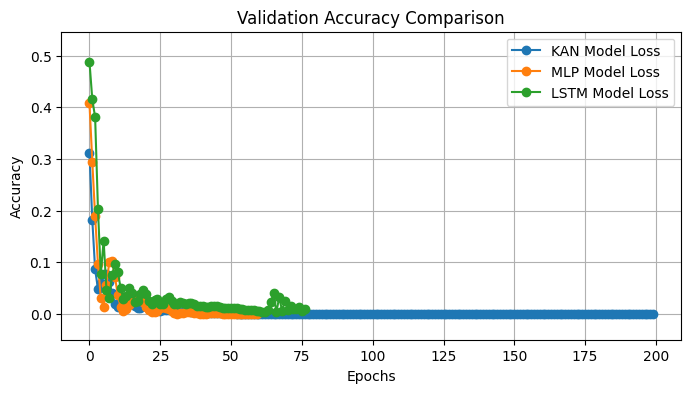

In [20]:
import matplotlib.pyplot as plt

# Epochs
# 정확도 플롯
plt.figure(figsize=(8, 4))
plt.plot(KAN_model_val_loss, label='KAN Model Loss', marker='o')
plt.plot(MLP_model_val_loss, label='MLP Model Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='LSTM Model Loss', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(np.min(MLP_model_train_loss)-0.05,np.max(MLP_model_train_loss)+0.05)
plt.show()